In [1]:
import paper_dataloaders
import paper_models

from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from seqdata.dualrnn import *
from seqdata.hpopt import *
from fastai.basics import *
from fastai.callback.all import *
from seqdata.quaternions import *
from pathlib import Path
from ray import tune
import pickle

from paper_dataloaders import *
from paper_models import *

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    'font.size': 14,
    'font.family': "Times New Roman"
})
# plt.rcParams['text.latex.preamble'] = r'\boldmath'

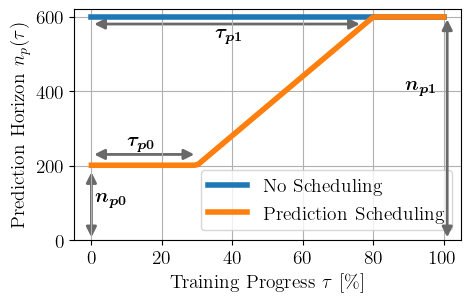

In [3]:
from matplotlib.patches import FancyArrowPatch
pred_sz = 600
epoch_pct = np.linspace(0,1,100)
plt.figure(figsize=(5,3))
plt.plot(epoch_pct*100,[pred_sz-sched_ramp(pred_sz-1,0,pct,0.0,0.0) for pct in epoch_pct],label='No Scheduling',lw=4)
plt.plot(epoch_pct*100,[pred_sz-sched_ramp(pred_sz-201,1,pct,0.3,0.8) for pct in epoch_pct],label='Prediction Scheduling',lw=4)
plt.legend(loc = 'lower right')
plt.xlabel(r'Training Progress $\tau$ [\%]')
plt.ylabel(r'Prediction Horizon $n_p(\tau)$')
plt.ylim(0)

plt.gca().add_patch(FancyArrowPatch((0, 0), (0, 190),
                        arrowstyle='<|-|>', mutation_scale=15,
                        color='dimgrey', lw=2))
plt.text(1, 100, r'\boldmath $n_{p0}$', horizontalalignment='left')

plt.gca().add_patch(FancyArrowPatch((101, 0), (101, 600),
                        arrowstyle='<|-|>', mutation_scale=15,
                        color='dimgrey', lw=2,zorder=10))
plt.text(98, 400, r'\boldmath $n_{p1}$', horizontalalignment='right')

plt.gca().add_patch(FancyArrowPatch((0, 230), (30, 230),
                        arrowstyle='<|-|>', mutation_scale=15,
                        color='dimgrey', lw=2))
plt.text(10, 250, r'\boldmath $\tau_{p0}$', horizontalalignment='left')

plt.gca().add_patch(FancyArrowPatch((0, 580), (77, 580),
                        arrowstyle='<|-|>', mutation_scale=15,
                        color='dimgrey', lw=2))
plt.text(35, 540, r'\boldmath$\tau_{p1}$', horizontalalignment='left')
plt.grid()

# plt.tight_layout()
plt.savefig('P4B_scheduling_example.pdf')

# Plot Results on datasets

In [4]:
import ray
from ray import tune
from fastai.basics import *
import pandas as pd
%matplotlib widget
ray.init() #auto is for attaching to a running local server

2024-06-28 10:09:12,710	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.10.14
Ray version:,2.23.0


In [5]:
import pickle
config = ['config/dl','config/size','config/pred_sz','config/schedule_pred']

experiment_path = Path.home() / 'ray_results/FranSys_P4B_models'
experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True)
df = df[df.training_iteration == 100].sort_values(config)
# pickle.dump(df, open('df_p4b_models.p', 'wb') )

#df = pickle.load(open('df_p4b_models.p', 'rb'))

2024-06-28 10:09:15,610	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 123 trial(s):
- learner_optimize_a08f9_00389: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00389: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00389_389_dl=Ship,pred_sz=300,size=small_2024-03-19_09-43-43')
- learner_optimize_a08f9_00390: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00390: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00390_390_dl=Quadrotor,pred_sz=500,size=small_2024-03-19_09-46-04')
- learner_optimize_a08f9_00391: FileNotFoundError('Could not fetch metrics for learner_optimize_a08f9_00391: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_models/learner_optimize_a08f9_00391_391_dl=Robot,pred_sz=500,size=small_2024-03-19_10-14-24')
- learner_opti

In [6]:
group_median = df.groupby(config)['_rmse'].transform('median')
df['median_diff'] = (df['_rmse'] - group_median).abs()
# For each group, find the row with the minimum difference to the group's median _rmse value
df_opt = df.loc[df.groupby(config)['median_diff'].idxmin()]
# Optionally, you can drop the 'median_diff' column if you no longer need it
df_opt = df_opt.drop(columns=['median_diff'])
# df_opt.loc[df_opt['config/dl'] == 'Ship','_rmse'] *= 1000
# df_opt.loc[df_opt['config/dl'] == 'Quadrotor','_rmse'] *= 100
df_opt[config + ['_rmse']]

,config/dl,config/size,config/pred_sz,config/schedule_pred,_rmse
25,Quadrotor,large,60,False,0.237876
657,Quadrotor,large,60,True,0.238097
147,Quadrotor,large,100,False,0.295608
1037,Quadrotor,large,100,True,0.295474
312,Quadrotor,large,200,False,0.377632
...,...,...,...,...,...
901,Ship,small,300,True,0.060466
284,Ship,small,500,False,0.098450
465,Ship,small,500,True,0.086468
341,Ship,small,700,False,0.123971


In [7]:
df_opt[df_opt['config/pred_sz'] == 200][config + ['_rmse']]

,config/dl,config/size,config/pred_sz,config/schedule_pred,_rmse
312,Quadrotor,large,200,False,0.377632
986,Quadrotor,large,200,True,0.377715
294,Quadrotor,medium,200,False,0.387944
575,Quadrotor,medium,200,True,0.387300
87,Quadrotor,small,200,False,0.387592
707,Quadrotor,small,200,True,0.386490
106,Robot,large,200,False,14.379354
540,Robot,large,200,True,14.426526
50,Robot,medium,200,False,15.750339
672,Robot,medium,200,True,15.985559


In [8]:
top5_per_group = df.groupby(config).apply(lambda x: x.sort_values('_rmse').head(5)).reset_index(drop=True).sort_values(config + ['_rmse']).sort_values('config/schedule_pred',ascending=True)
top5_per_group

/tmp/ipykernel_3710778/2530555410.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_per_group = df.groupby(config).apply(lambda x: x.sort_values('_rmse').head(5)).reset_index(drop=True).sort_values(config + ['_rmse']).sort_values('config/schedule_pred',ascending=True)


,train_loss,valid_loss,_rmse,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,...,config/opt_beta,config/lr,config/init_pred,config/p_left,config/p_right,config/create_lrn,config/dls,config/fit_method,logdir,median_diff
0,0.071001,0.142180,0.236218,1710861280,checkpoint_000099,True,False,100,a08f9_00360,2024-03-19_16-14-40,...,4859.588076,0.002276,101.046427,0.154176,0.620835,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),a08f9_00360,0.001658
313,2.462002,8.045543,13.414489,1710788160,checkpoint_000099,True,False,100,a08f9_00058,2024-03-18_19-56-00,...,118.410665,0.009256,141.766132,0.398813,0.687604,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),a08f9_00058,0.109226
360,0.036029,0.018435,0.033384,1710821355,checkpoint_000099,True,False,100,a08f9_00200,2024-03-19_05-09-15,...,2641.155324,0.000635,95.607461,0.133123,0.682660,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),a08f9_00200,0.000085
180,0.943277,6.172976,10.519810,1710780970,checkpoint_000099,True,False,100,a08f9_00037,2024-03-18_17-56-10,...,192.017649,0.005843,138.243542,0.123658,0.888306,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),a08f9_00037,0.261612
181,0.951594,6.081630,10.715790,1710821387,checkpoint_000099,True,False,100,a08f9_00199,2024-03-19_05-09-47,...,192.017649,0.005843,138.243542,0.123658,0.888306,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),a08f9_00199,0.065632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.000106,9.866693,15.334265,1710902614,checkpoint_000099,True,False,100,1d8f7_00160,2024-03-20_03-43-34,...,192.017649,0.005843,131.713125,0.252515,0.772394,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),1d8f7_00160,1.119429
229,0.971121,9.972777,15.877927,1710921878,checkpoint_000099,True,False,100,1d8f7_00265,2024-03-20_09-04-38,...,192.017649,0.005843,131.713125,0.252515,0.772394,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),1d8f7_00265,0.014341
228,1.003171,10.163606,15.815678,1710964223,checkpoint_000099,True,False,100,1d8f7_00481,2024-03-20_20-50-23,...,192.017649,0.005843,131.713125,0.252515,0.772394,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),1d8f7_00481,0.076591
226,1.030352,9.774645,15.384154,1710879718,checkpoint_000099,True,False,100,1d8f7_00049,2024-03-19_21-21-58,...,192.017649,0.005843,131.713125,0.252515,0.772394,ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505),ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000003e1f505),1d8f7_00049,0.508114


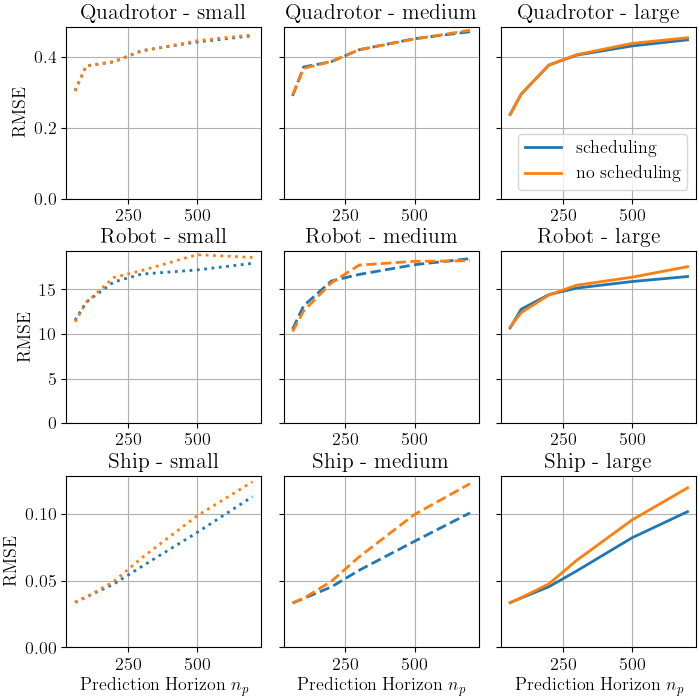

In [9]:
import seaborn as sns
plt.rcParams['font.size'] = 13
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
linestyles = {'small': ':', 'medium': '--', 'large': '-'}
sizes = ['small', 'medium', 'large']
datasets = df['config/dl'].unique()

for i, size in enumerate(sizes):
    for j, dataset in enumerate(datasets):
        # Filtering data for the current dataset and size
        df_subset = df[(df['config/dl'] == dataset) & (df['config/size'] == size)]
        ax = axes[j, i]
        
        # Since seaborn's lineplot may not directly accept a 'dashes' parameter with a dictionary as we initially attempted,
        # we will apply the linestyles after plotting by accessing the lines drawn by seaborn and setting their linestyles.
        sns.lineplot(data=df_subset, x='config/pred_sz', y='_rmse', hue='config/schedule_pred',hue_order=[1,0],errorbar=None,lw=2, ax=ax,estimator='median')
        
        # Setting line styles post-hoc
        lines = ax.get_lines()  # Get the lines that seaborn has plotted
        for line in lines:
            line.set_linestyle(linestyles[size])  # Set linestyle based on the model size
        
        # ax.set_ylim(0)
        ax.grid()
        ax.legend().set_visible(False)  # Hide legend to avoid repetition
        ax.set_title(f"{dataset} - {size}")
        if i > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('RMSE')
        if j < 2:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Prediction Horizon $n_p$')
for idx_row in range(axes.shape[0]):
    y_max = max([ax.get_ylim()[-1] for ax in axes[idx_row,:]])
    for ax in axes[idx_row,:]:
        ax.set_ylim(0,y_max)
            
ax = axes[0, 2]
handles, labels = ax.get_legend_handles_labels()
labels[1]='no scheduling'
labels[0]='scheduling'
ax.legend(handles=handles, labels=labels,title=None, loc='lower right')

plt.tight_layout(pad=0.2)
plt.savefig('P4B_individual.pdf')

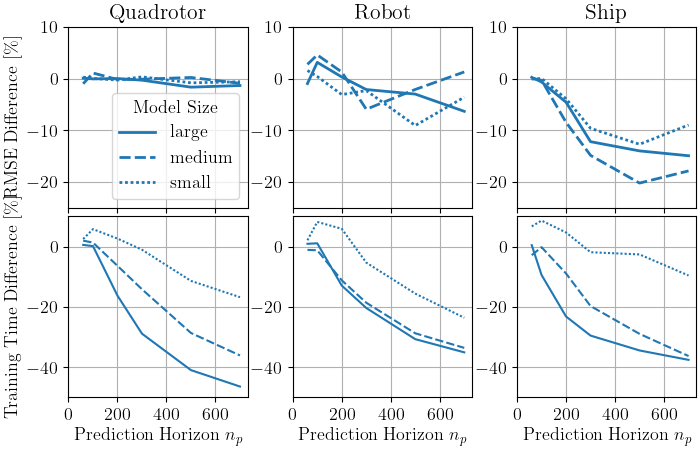

In [10]:
# Adjusting the code to use seaborn lineplot for plotting

df_improvement = df.copy()
df_improvement['schedule_pred_bool'] = df_improvement['config/schedule_pred'].astype(str) == 'True'

# Recalculate improvements with corrected boolean handling using median
rmse_improvement = df_improvement.groupby(['config/dl', 'config/size', 'config/pred_sz', 'schedule_pred_bool'])['_rmse'].median().unstack()
training_time_improvement = df_improvement.groupby(['config/dl', 'config/size', 'config/pred_sz', 'schedule_pred_bool'])['time_total_s'].min().unstack()

# Calculate improvement ratios with corrected approach
rmse_improvement_ratio = ((rmse_improvement[True] / rmse_improvement[False])-1)*100
training_time_improvement_ratio = ((training_time_improvement[True] / training_time_improvement[False])-1)*100

# Reset index for seaborn plotting
rmse_improvement_ratio_reset = rmse_improvement_ratio.reset_index()
training_time_improvement_ratio_reset = training_time_improvement_ratio.reset_index()

# Melting the dataframes for seaborn
rmse_melted = rmse_improvement_ratio_reset.melt(id_vars=['config/dl', 'config/size', 'config/pred_sz'], value_name='Relative RMSE [%]', var_name='Metric')
time_melted = training_time_improvement_ratio_reset.melt(id_vars=['config/dl', 'config/size', 'config/pred_sz'], value_name='Relative Training Time [%]', var_name='Metric')

fig, axes = plt.subplots(2, 3, figsize=(7, 4.5))

for i, dataset in enumerate(datasets):
    # RMSE Improvement Plot
    sns.lineplot(data=rmse_melted[rmse_melted['config/dl'] == dataset], lw=2,
                 x='config/pred_sz', y='Relative RMSE [%]', style='config/size', ax=axes[0, i])
    # axes[0, i].set_title(f"{dataset} - Relative RMSE")
    axes[0, i].set_title(f"{dataset}")
    axes[0, i].set_ylabel(r'RMSE Difference [\%]' if i == 0 else '')
    axes[0, i].set_xlabel(None)
    axes[0, i].set_xticks([0,200,400,600],labels=[])
    axes[0, i].set_ylim(-25, 10)
    axes[0, i].grid()
    axes[0, i].legend().set_visible(False)  # Hide legend to avoid repetition

    # Training Time Improvement Plot
    sns.lineplot(data=time_melted[time_melted['config/dl'] == dataset], 
                 x='config/pred_sz', y='Relative Training Time [%]', style='config/size', ax=axes[1, i])
    # axes[1, i].set_title(f"{dataset} - Relative Training Time")
    axes[1, i].set_ylabel('Training Time Difference [\%]' if i == 0 else '')
    axes[1, i].set_xlabel('Prediction Horizon $n_p$')
    axes[1, i].set_xticks([0,200,400,600])
    axes[1, i].legend().set_visible(False)  # Hide legend to avoid repetition
    axes[1, i].set_ylim(-50, 10)
    axes[1, i].grid()


axes[0, 0].legend(title='Model Size', loc='lower right',fontsize='medium')

plt.tight_layout(pad=0.2)
plt.show()
plt.savefig('P4B_effect.pdf')


# Plot Ablation

In [11]:
experiment_path = Path.home() / 'ray_results/FranSys_P4B_ablation'
experiments = get_files(experiment_path,'.json').filter(lambda x: 'experiment_state' in x.name)
experiment_list = [tune.ExperimentAnalysis(e,default_metric='_rmse',default_mode='min') for e in experiments]
df_abl = pd.concat([e.dataframe() for e in experiment_list],ignore_index=True).sort_values('_rmse')
trials = list(flatten([exp.trials for exp in experiment_list]))
df_abl['trial'] = df_abl.trial_id.apply(lambda t_id: first(trials, lambda y: y.trial_id == t_id))
df_abl = df_abl[df_abl.training_iteration ==100]

2024-06-28 10:09:29,856	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 44 trial(s):
- learner_optimize_079b7_01790: FileNotFoundError('Could not fetch metrics for learner_optimize_079b7_01790: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_ablation/learner_optimize_079b7_01790_1790_dl=Ship,init_pred=60,p_left=0.3000,p_right=0.9000_2024-03-18_12-16-15')
- learner_optimize_079b7_01791: FileNotFoundError('Could not fetch metrics for learner_optimize_079b7_01791: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_ablation/learner_optimize_079b7_01791_1791_dl=Quadrotor,init_pred=90,p_left=0.3000,p_right=0.9000_2024-03-18_12-23-38')
- learner_optimize_079b7_01792: FileNotFoundError('Could not fetch metrics for learner_optimize_079b7_01792: both result.json and progress.csv were not found at /home/pheenix/ray_results/FranSys_P4B_ablation/learner_optimize_079b7_01792_1792_dl=Robot,init_pred=90,

In [12]:
df_abl0 = df[(df['config/pred_sz'] == 300) & (df['config/schedule_pred'] == False)].copy()
df_abl0['config/ablation'] = 0
df_abl4 = df[(df['config/pred_sz'] == 300) & (df['config/schedule_pred'] == True)].copy()
df_abl4['config/ablation'] = 4
df_ablation = pd.concat([df_abl0,df_abl,df_abl4])

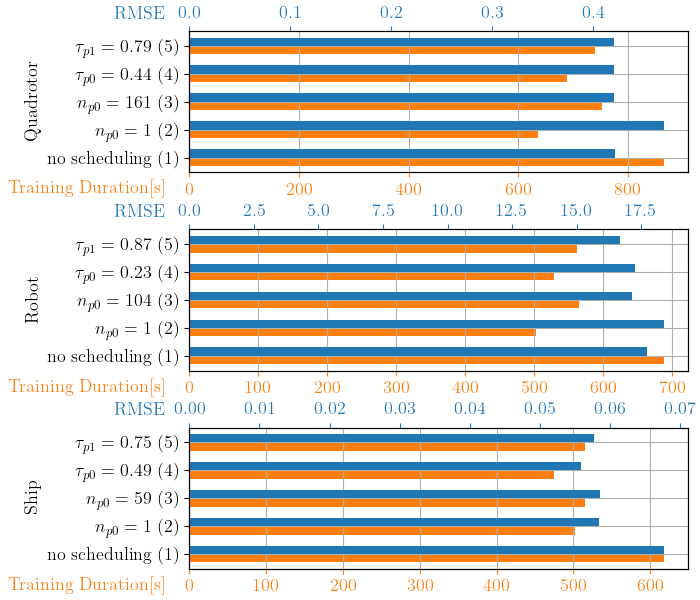

In [13]:
groups = ['config/dl','config/size','config/ablation']
clms = ['config/init_pred', 'config/p_left', 'config/p_right','_rmse','time_total_s']

fig, axes = plt.subplots(3, 1, figsize=(7, 6))

palette = sns.color_palette()
color_rmse = palette[0]  # First color for RMSE
color_train_speed = palette[1]  # Second color for Training Speed
bar_width = 0.3

dls = df_ablation['config/dl'].unique()
size = 'medium'

for i,dl in enumerate(dls):
    # Filtering data for the current dataset    
    df_subset = df_ablation[(df_ablation['config/size'] == size) & (df_ablation['config/dl'] == dl)] \
        .sort_values('config/ablation') \
        .groupby(groups, as_index=False)[clms].median() \
        .reset_index()
    
    scheduling_methods=[
       r'no scheduling (1)',
       r'$n_{p0}=1$ (2)',
       r'$n_{p0}='+ str(int(df_subset.iloc[2]['config/init_pred'].copy())) +'$ (3)',
       rf"$\tau_{{p0}}={df_subset.iloc[3]['config/p_left']:0.2f}$ (4)",
       rf"$\tau_{{p1}}={df_subset.iloc[4]['config/p_right']:0.2f}$ (5)"
    ]
    bar_positions = np.arange(len(scheduling_methods))

    # RMSE bars
    ax_rmse = axes[i].twiny()  # Creating a twin x-axis for RMSE on top
    ax_rmse.barh(bar_positions + bar_width/2, df_subset['_rmse'], height=bar_width, color=color_rmse, label='RMSE')
    # ax_rmse.set_xlabel('RMSE', color=color_rmse)
    ax_rmse.tick_params(axis='x', colors=color_rmse)
    ax_rmse.text(-0.05, 1.12, 'RMSE', transform=ax_rmse.transAxes, color=color_rmse, va='center', ha='right')

    # Training Speed bars
    ax_train_speed = axes[i]
    ax_train_speed.barh(bar_positions - bar_width/2, df_subset['time_total_s'], height=bar_width, color=color_train_speed, label='Training Duration[s]')
    # ax_train_speed.set_xlabel('Training Duration[s]', color=color_train_speed)
    ax_train_speed.tick_params(axis='x', colors=color_train_speed)
    ax_train_speed.text(-0.05, -0.12, 'Training Duration[s]', transform=ax_train_speed.transAxes, color=color_train_speed, va='center', ha='right')

    # Setting the y-axis labels and chart title
    axes[i].set_yticks(bar_positions)
    axes[i].set_yticklabels(scheduling_methods)
    axes[i].grid()
    
    axes[i].set_ylabel(dl)
    # axes[i].yaxis.set_label_position("right")


# Adding a legend
handles_rmse, labels_rmse = ax_rmse.get_legend_handles_labels()
handles_train_speed, labels_train_speed = ax_train_speed.get_legend_handles_labels()

plt.tight_layout(pad=0.3)
plt.savefig('P4B_ablation.pdf')